<a href="https://colab.research.google.com/github/Rymbekova/MLProject/blob/master/Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data pre-processing step.



Prior to visualization I followed Seurat clustering workflow. Once started by reading in the data, I next used the count matrix to create a Seurat object. The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for a single-cell dataset. The next step is to normalize the data with the default values of parameters. Next I calculated a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others) via FindVariableFeatures function. Then scaling, which is a standard pre-processing step prior to dimensional reduction techniques. On the scaled data I performed PCA. Finally, to cluster cells, I applied a graph-based clustering approach. First, construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods - FindNeighbors function. Then FindClusters function attempts to partition this graph into highly interconnected 'quasi-cliques' or 'communities' by the Louvain algorithm which is robust for high-dimensional data. This workflow resulted in detecting 14 clusters in the dataset.

In [ ]:
setwd("~/Desktop/Machine Learning")
data <- read.csv(file = "data.csv", row.names = 1)
data <- CreateSeuratObject(counts = data)
data <- NormalizeData(data)
data <- FindVariableFeatures(data)
data <- ScaleData(data)
data <- RunPCA(object = data, verbose = FALSE)
data <- FindNeighbors(data, reduction = "pca", dims = 1:20)
data <- FindClusters(data, genes.use = NULL, pc.use = NULL, k.param = 30,
                        k.scale = 25, plot.SNN = FALSE, prune.SNN = 1/15, save.SNN = FALSE,
                        reuse.SNN = FALSE, do.sparse = FALSE, modularity.fxn = 1,
                        resolution = 0.8, algorithm = 1, n.start = 100, n.iter = 10,
                        random.seed = 0, print.output = TRUE)


The final file is in tabular format with cells as rows and genes as columns. For each cell the value of the last column is the number of the assigned cluster.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gotov.csv to gotov.csv


Upload the file and load it onto a pandas.DataFrame

In [ ]:
import pandas as pd
expr = pd.read_csv('gotov.csv', index_col='FIELD1')
expr = expr.dropna()
expr.shape
del expr['Unnamed: 0']
expr

,A2M-AS1,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,ABAT,ABCA1,ABCA5,ABCA7,ABCB1,ABCB10,ABCB4,ABCB7,ABCB8,ABCB9,ABCC1,ABCC10,ABCC4,ABCC5,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABHD10,ABHD13,ABHD14B,ABHD15,ABHD17A,...,VSIG1,VWA5A,WBP5,WDR27,WDR86,WDR86-AS1,ZBTB22,ZBTB34,ZBTB49,ZBTB5,ZDHHC12,ZFAT,ZFP28,ZFP37,ZFYVE9,ZNF140,ZNF2,ZNF212,ZNF225,ZNF30,ZNF343,ZNF418,ZNF449,ZNF460,ZNF540,ZNF571,ZNF582-AS1,ZNF599,ZNF619,ZNF627,ZNF717,ZNF724P,ZNF776,ZNF778,ZNF823,ZNF850,ZSCAN21,ZXDB,hsa-mir-8072,Cluster
FIELD1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CD8_high_AAAACCATGACG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
CD8_high_AAAGTGTATTCC,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
CD8_high_AAATCGGATCTC,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
CD8_high_AACCACCGATAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
CD8_high_AACCGGCGCAGG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD8_off_TTGTCTTATTCA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
CD8_off_TTGTTGTAGAAA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
CD8_off_TTTAGAGTAGGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


This is how my final dataset looks like: the original dataset is single cell rna seq from the Cite-seq paper. Cells were classified by flow cytometry as low, medium, or high cd8 expression cells (rows), with columns corresponding to RNA counts.

In [ ]:
#importing needed libraries for our first strategy
import numpy as np
import pandas as pd
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Sequential, Model

#reading data and assigning X to all values except the last column and Y is the last column values
#expr = pd.read_csv('gotov.csv')
#expr = expr.dropna()
X = expr.values[:,0:(expr.shape[1]-1)]
Y = expr.values[:,expr.shape[1]-1]

Text(0, 0.5, 'PC2')

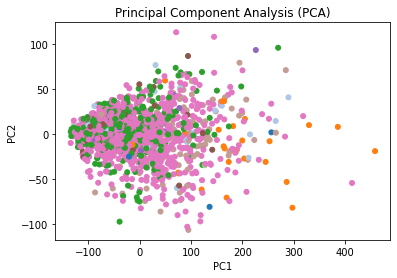

In [ ]:
#now reducing dimensionality with Principal Component Analysis 
n_input = 20
x_train = PCA(n_components = n_input).fit_transform(X); y_train = Y
plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, cmap = 'tab20', s = 25)
plt.title('Principal Component Analysis (PCA)')
plt.xlabel("PC1")
plt.ylabel("PC2")

Here is a produced PCA plot where one point is one cell and the colors correspond to different cell types. Supposedly, 14 cell populations should be observed but basically we can not see them because cells heavily overlap. The reason is PCA linear dimensionality reduction can not resolve the single cell structure.

It is a common practice is to perform a linear PCA as a pre-dimensionality reduction and feed the output into the tSNE (t-distributed Stochastic Neighbor Embedding), which is a current golden standard non-linear dimensionality reduction technique in scRNAseq area. The problem is a poor scaling of tSNE: as the numbers of cells increases, it is more and more difficult to handle the data.

Text(0, 0.5, 'tSNE2')

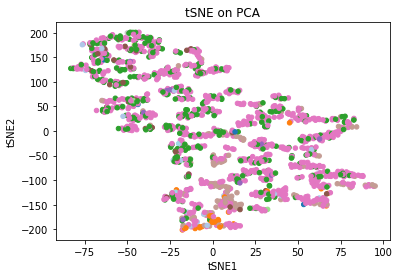

In [ ]:
#performing tsne on pca
from sklearn.manifold import TSNE
model_tsne = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                  perplexity = 10, n_iter = 10000)
tsne = model_tsne.fit_transform(x_train)
plt.scatter(tsne[:, 0], tsne[:, 1], c = y_train, cmap = 'tab20', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Generally, tSNE provided some cell blobs of different colors like orange points accumulated in the lower part of the plot. Other colors like pink, green, dark brown, light brown, light blue are smeared all around. Unfortunately in the case of this dataset, we do not have a prior knowledge of all cell types to use markers and easily interpret the clustering. Perhaps, some kinds of cells are meant to be closer to each other or intermingled.

Autoencoder is an unsupervised Artificial Neural Network with the “butterfly” architecture which is often used for dimensionality reduction. In contrast to linear techniques such as PCA, Autoencoders perform non-linear dimensionality reduction and hence can possibly capture highly non-linear structure of single cell data. Here again, I performed first a pre-dimensionality step and then fed it into the tSNE.

Epoch 1/500
23/23 [==============================] - 1s 28ms/step - loss: 2.8466
Epoch 2/500
23/23 [==============================] - 1s 29ms/step - loss: 2.5489
Epoch 3/500
23/23 [==============================] - 1s 30ms/step - loss: 2.6622
Epoch 4/500
23/23 [==============================] - 1s 29ms/step - loss: 2.7169
Epoch 5/500
23/23 [==============================] - 1s 29ms/step - loss: 2.5691
Epoch 6/500
23/23 [==============================] - 1s 30ms/step - loss: 2.6082
Epoch 7/500
23/23 [==============================] - 1s 29ms/step - loss: 2.5786
Epoch 8/500
23/23 [==============================] - 1s 29ms/step - loss: 2.6577
Epoch 9/500
23/23 [==============================] - 1s 29ms/step - loss: 2.4539
Epoch 10/500
23/23 [==============================] - 1s 28ms/step - loss: 2.6658
Epoch 11/500
23/23 [==============================] - 1s 30ms/step - loss: 2.6356
Epoch 12/500
23/23 [==============================] - 1s 29ms/step - loss: 2.7564
Epoch 13/500
23/23 [=====

Text(0, 0.5, 'Dimension 2')

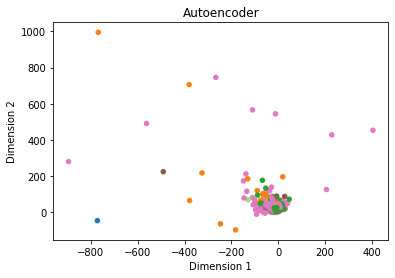

In [ ]:
#first reducing dimensionality with Autoencoder Neural Network
n_input = 11757
x_train = X; y_train = Y
model = Sequential()
model.add(Dense(30,       activation='elu', input_shape=(n_input,)))
model.add(Dense(20,       activation='elu'))
model.add(Dense(10,       activation='elu'))
model.add(Dense(2,        activation='linear', name="bottleneck"))
model.add(Dense(10,       activation='elu'))
model.add(Dense(20,       activation='elu'))
model.add(Dense(30,       activation='elu'))
model.add(Dense(n_input,  activation='sigmoid'))
model.compile(loss = 'mse', optimizer = Adam())
model.fit(x_train, x_train, batch_size = 64, epochs = 500, verbose = 1)
encoder = Model(model.input, model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(x_train)
plt.scatter(bottleneck_representation[:,0], bottleneck_representation[:,1], 
            c = y_train, s = 20, cmap = 'tab20')
plt.title('Autoencoder')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

Again, no distinctive clusters can be seen as cells overlap heavily. Next step is performing tSNE on Autoencoder.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1431 samples in 0.003s...
[t-SNE] Computed neighbors for 1431 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1431
[t-SNE] Computed conditional probabilities for sample 1431 / 1431
[t-SNE] Mean sigma: 1.648248
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.516632
[t-SNE] KL divergence after 1000 iterations: 0.382206


Text(0, 0.5, 'tSNE2')

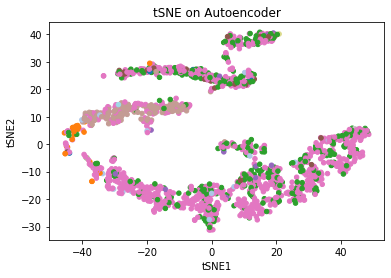

In [ ]:
#performing tsne on autoencoder
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 40, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y, cmap = 'tab20', s = 20)
plt.title('tSNE on Autoencoder')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Finally, we can see that orange points are again grouped together at the left of the plot, then there are light brown dots forming a long grouped range. Pink, green and brown points seem distributed all around the plot, but on the lower part of the plot we can see more pink dots clustered. At the top cluster there are predominantly green dots and some dark brown ones. 

Even though the final plot did not provide clearly detectable different cell populations, for this particular case, tSNE on Autoencoder seems to provide more dense clusters especially for light brown population. It previously was smeared throughout the lower part of the plot, now has formed a ranged cluster. Again, interpretation of the clusters is quite not possible but it seems that clusters are formed with different kinds of cells that are intermingled. However, in each cluster one or two kinds of cells might be predominant.

One interesting point that brought my attention is perplexity, a tuneable parameter of tSNE. Generally, this parameter is a guess about the number of close neighbors each point has. It turned out that analyzing different perplexity values you end up with multiple different plots. The range of values is generally between 5 to 50, in this project value of 40 was set and the resulting plot was the most satisfying.

In this project, I demonstrated the difference in single cell resolution between linear  and non-linear dimensionality reduction techniques. The first approach using PCA and then tSNE took less than two minutes of computational time. The Deep Learning approach using Autoencoder and tSNE was more computationally expensive - it took more than seven minutes. Even in this case of using a fairly small dataset the difference in timing was clear. One should take this into consideration when working with very large datasets.

To conclude, I believe Deep Learning is promising for improving resolution of  dimensionality reduction and clustering of different cell populations. 